In [23]:
import optuna
import torch
import torchvision.transforms as transforms
import torch.nn as nn

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, TensorDataset, Subset
import torch.optim as optim
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [25]:
data_dir = "data/raw-img" 

In [26]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float16),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [27]:
full_dataset = ImageFolder(root=data_dir, transform=transform)
class_names = full_dataset.classes

In [28]:
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

In [29]:
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

In [30]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, pin_memory=True)

In [31]:
class MyModel(nn.Module):
    def __init__(self, fc_layers: tuple, dropout: float):
        super(MyModel, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout(dropout)
        
        self.flatten = nn.Flatten()
        self.linear_relu_stack = self.__generate_stack(fc_layers, dropout)
        
    def forward(self, x):
        x = self.maxpool(self.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.maxpool(self.relu(self.conv2(x)))
        x = self.maxpool(self.relu(self.conv3(x)))
        x = self.dropout(x)
        x = self.maxpool(self.relu(self.conv4(x)))
        x = self.maxpool(self.relu(self.conv5(x)))
        x = self.dropout(x)
        
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        return x
    
    def __generate_stack(self, size: tuple, dropout: float):
        layers = []
        for i in range(len(size) - 1):
            layers.append(nn.Linear(size[i], size[i + 1]))
            if i < len(size) - 2:
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(dropout))
        return nn.Sequential(*layers)


In [32]:
def objective(trial):
    hidden_units = trial.suggest_categorical('fc_layers', [
        (12544, 10),
        (12544, 256, 10),
        (12544, 256, 128, 10)
    ])
    dropout_rate = trial.suggest_categorical('dropout_rate', [0, 0.25])
    learning_rate = trial.suggest_categorical('learning_rate', [0.001, 0.0001, 0.01])
    
    model = MyModel(hidden_units, dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scaler = torch.amp.GradScaler('cuda')
    
    train_losses = []
    test_losses = []
    f1_scores = []
    
    for epoch in range(25):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
    
            with torch.amp.autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch+1}/25, Train Loss: {avg_train_loss:.4f}")
        
        model.eval()
        all_preds = []
        all_labels = []
        test_running_loss = 0.0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                
                with torch.amp.autocast('cuda'):
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                
                test_running_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        avg_test_loss = test_running_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        
        f1 = f1_score(all_labels, all_preds, average='weighted')
        f1_scores.append(f1)
        
        print(f"Test Loss: {avg_test_loss:.4f}, Test F1-Score: {f1:.4f}")
        
        trial.set_user_attr(f"train_loss_epoch_{epoch+1}", avg_train_loss)
        trial.set_user_attr(f"test_loss_epoch_{epoch+1}", avg_test_loss)
        trial.set_user_attr(f"f1_epoch_{epoch+1}", f1)
        
    return f1


In [33]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2025-03-27 20:18:31,790] A new study created in memory with name: no-name-7a1772ee-4f57-4144-83a7-49890441019c
C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 256, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 256, 128, 10) which is of type tuple.
  warnings.warn(m

Epoch 1/25, Train Loss: 18.3805
Test Loss: 2.2151, Test F1-Score: 0.0574
Epoch 2/25, Train Loss: 2.2075
Test Loss: 2.2137, Test F1-Score: 0.0574
Epoch 3/25, Train Loss: 2.2060
Test Loss: 2.2139, Test F1-Score: 0.0549
Epoch 4/25, Train Loss: 2.2066
Test Loss: 2.2128, Test F1-Score: 0.0574
Epoch 5/25, Train Loss: 2.2060
Test Loss: 2.2133, Test F1-Score: 0.0549
Epoch 6/25, Train Loss: 2.2052
Test Loss: 2.2144, Test F1-Score: 0.0549
Epoch 7/25, Train Loss: 2.2055
Test Loss: 2.2129, Test F1-Score: 0.0574
Epoch 8/25, Train Loss: 2.2059
Test Loss: 2.2137, Test F1-Score: 0.0549
Epoch 9/25, Train Loss: 2.2053
Test Loss: 2.2140, Test F1-Score: 0.0549
Epoch 10/25, Train Loss: 2.2058
Test Loss: 2.2136, Test F1-Score: 0.0574
Epoch 11/25, Train Loss: 2.2054
Test Loss: 2.2136, Test F1-Score: 0.0549
Epoch 12/25, Train Loss: 2.2057
Test Loss: 2.2142, Test F1-Score: 0.0574
Epoch 13/25, Train Loss: 2.2053
Test Loss: 2.2133, Test F1-Score: 0.0574
Epoch 14/25, Train Loss: 2.2057
Test Loss: 2.2129, Test F1-

[I 2025-03-27 20:58:52,258] Trial 0 finished with value: 0.05737146539692102 and parameters: {'fc_layers': (12544, 256, 10), 'dropout_rate': 0.25, 'learning_rate': 0.01}. Best is trial 0 with value: 0.05737146539692102.


Test Loss: 2.2138, Test F1-Score: 0.0574


C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 256, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 256, 128, 10) which is of type tuple.
  warnings.warn(message)


Epoch 1/25, Train Loss: 1.9916
Test Loss: 1.7949, Test F1-Score: 0.3002
Epoch 2/25, Train Loss: 1.6760
Test Loss: 1.6227, Test F1-Score: 0.4085
Epoch 3/25, Train Loss: 1.5308
Test Loss: 1.4948, Test F1-Score: 0.4607
Epoch 4/25, Train Loss: 1.4437
Test Loss: 1.4251, Test F1-Score: 0.4959
Epoch 5/25, Train Loss: 1.3654
Test Loss: 1.3725, Test F1-Score: 0.5202
Epoch 6/25, Train Loss: 1.2993
Test Loss: 1.3232, Test F1-Score: 0.5269
Epoch 7/25, Train Loss: 1.2336
Test Loss: 1.2443, Test F1-Score: 0.5791
Epoch 8/25, Train Loss: 1.1728
Test Loss: 1.2260, Test F1-Score: 0.5722
Epoch 9/25, Train Loss: 1.1178
Test Loss: 1.1803, Test F1-Score: 0.5951
Epoch 10/25, Train Loss: 1.0702
Test Loss: 1.1429, Test F1-Score: 0.6129
Epoch 11/25, Train Loss: 1.0275
Test Loss: 1.0942, Test F1-Score: 0.6284
Epoch 12/25, Train Loss: 0.9842
Test Loss: 1.1020, Test F1-Score: 0.6349
Epoch 13/25, Train Loss: 0.9559
Test Loss: 1.1031, Test F1-Score: 0.6292
Epoch 14/25, Train Loss: 0.9192
Test Loss: 1.0694, Test F1-S

[I 2025-03-27 21:39:44,831] Trial 1 finished with value: 0.6809532652443586 and parameters: {'fc_layers': (12544, 256, 10), 'dropout_rate': 0, 'learning_rate': 0.0001}. Best is trial 1 with value: 0.6809532652443586.


Test Loss: 1.0464, Test F1-Score: 0.6810


C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 256, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 256, 128, 10) which is of type tuple.
  warnings.warn(message)


Epoch 1/25, Train Loss: 2.0452
Test Loss: 1.7904, Test F1-Score: 0.3197
Epoch 2/25, Train Loss: 1.6960
Test Loss: 1.6688, Test F1-Score: 0.3588
Epoch 3/25, Train Loss: 1.5672
Test Loss: 1.5430, Test F1-Score: 0.4414
Epoch 4/25, Train Loss: 1.4506
Test Loss: 1.4225, Test F1-Score: 0.5004
Epoch 5/25, Train Loss: 1.3506
Test Loss: 1.3502, Test F1-Score: 0.5290
Epoch 6/25, Train Loss: 1.2749
Test Loss: 1.3340, Test F1-Score: 0.5461
Epoch 7/25, Train Loss: 1.2011
Test Loss: 1.2138, Test F1-Score: 0.5839
Epoch 8/25, Train Loss: 1.1380
Test Loss: 1.2125, Test F1-Score: 0.5863
Epoch 9/25, Train Loss: 1.0867
Test Loss: 1.1628, Test F1-Score: 0.6028
Epoch 10/25, Train Loss: 1.0340
Test Loss: 1.1471, Test F1-Score: 0.6031
Epoch 11/25, Train Loss: 0.9926
Test Loss: 1.0976, Test F1-Score: 0.6371
Epoch 12/25, Train Loss: 0.9540
Test Loss: 1.0733, Test F1-Score: 0.6375
Epoch 13/25, Train Loss: 0.9128
Test Loss: 1.0423, Test F1-Score: 0.6484
Epoch 14/25, Train Loss: 0.8782
Test Loss: 1.0498, Test F1-S

[I 2025-03-27 22:03:02,770] Trial 2 finished with value: 0.6748583373254405 and parameters: {'fc_layers': (12544, 256, 10), 'dropout_rate': 0, 'learning_rate': 0.0001}. Best is trial 1 with value: 0.6809532652443586.


Test Loss: 1.0305, Test F1-Score: 0.6749


C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 256, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 256, 128, 10) which is of type tuple.
  warnings.warn(message)


Epoch 1/25, Train Loss: 1.8097
Test Loss: 1.4930, Test F1-Score: 0.4739
Epoch 2/25, Train Loss: 1.3493
Test Loss: 1.2266, Test F1-Score: 0.5779
Epoch 3/25, Train Loss: 1.1200
Test Loss: 1.0910, Test F1-Score: 0.6235
Epoch 4/25, Train Loss: 0.9843
Test Loss: 1.0162, Test F1-Score: 0.6642
Epoch 5/25, Train Loss: 0.8795
Test Loss: 0.9584, Test F1-Score: 0.6786
Epoch 6/25, Train Loss: 0.7876
Test Loss: 0.8804, Test F1-Score: 0.7068
Epoch 7/25, Train Loss: 0.6947
Test Loss: 0.8818, Test F1-Score: 0.7079
Epoch 8/25, Train Loss: 0.6140
Test Loss: 0.9240, Test F1-Score: 0.7069
Epoch 9/25, Train Loss: 0.5535
Test Loss: 0.8565, Test F1-Score: 0.7313
Epoch 10/25, Train Loss: 0.4679
Test Loss: 0.8536, Test F1-Score: 0.7440
Epoch 11/25, Train Loss: 0.4192
Test Loss: 0.9654, Test F1-Score: 0.7132
Epoch 12/25, Train Loss: 0.3590
Test Loss: 0.8684, Test F1-Score: 0.7471
Epoch 13/25, Train Loss: 0.3130
Test Loss: 0.9149, Test F1-Score: 0.7324
Epoch 14/25, Train Loss: 0.2694
Test Loss: 0.9106, Test F1-S

[I 2025-03-27 22:20:48,508] Trial 3 finished with value: 0.7466657161916486 and parameters: {'fc_layers': (12544, 10), 'dropout_rate': 0, 'learning_rate': 0.001}. Best is trial 3 with value: 0.7466657161916486.


Test Loss: 1.5692, Test F1-Score: 0.7467


C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 256, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 256, 128, 10) which is of type tuple.
  warnings.warn(message)


Epoch 1/25, Train Loss: 8.6603
Test Loss: 2.2160, Test F1-Score: 0.0574
Epoch 2/25, Train Loss: 2.2077
Test Loss: 2.2137, Test F1-Score: 0.0549
Epoch 3/25, Train Loss: 2.2074
Test Loss: 2.2161, Test F1-Score: 0.0549
Epoch 4/25, Train Loss: 2.2067
Test Loss: 2.2151, Test F1-Score: 0.0549
Epoch 5/25, Train Loss: 2.2063
Test Loss: 2.2133, Test F1-Score: 0.0549
Epoch 6/25, Train Loss: 2.2061
Test Loss: 2.2130, Test F1-Score: 0.0574
Epoch 7/25, Train Loss: 2.2064
Test Loss: 2.2132, Test F1-Score: 0.0574
Epoch 8/25, Train Loss: 2.2066
Test Loss: 2.2143, Test F1-Score: 0.0549
Epoch 9/25, Train Loss: 2.2057
Test Loss: 2.2129, Test F1-Score: 0.0574
Epoch 10/25, Train Loss: 2.2054
Test Loss: 2.2139, Test F1-Score: 0.0574
Epoch 11/25, Train Loss: 2.2059
Test Loss: 2.2136, Test F1-Score: 0.0549
Epoch 12/25, Train Loss: 2.2055
Test Loss: 2.2130, Test F1-Score: 0.0574
Epoch 13/25, Train Loss: 2.2056
Test Loss: 2.2130, Test F1-Score: 0.0574
Epoch 14/25, Train Loss: 2.2051
Test Loss: 2.2129, Test F1-S

[I 2025-03-27 22:38:38,719] Trial 4 finished with value: 0.05737146539692102 and parameters: {'fc_layers': (12544, 256, 10), 'dropout_rate': 0, 'learning_rate': 0.01}. Best is trial 3 with value: 0.7466657161916486.


Test Loss: 2.2133, Test F1-Score: 0.0574


C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 256, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 256, 128, 10) which is of type tuple.
  warnings.warn(message)


Epoch 1/25, Train Loss: 3.6132
Test Loss: 1.9604, Test F1-Score: 0.2387
Epoch 2/25, Train Loss: 1.8713
Test Loss: 1.8432, Test F1-Score: 0.3122
Epoch 3/25, Train Loss: 1.7051
Test Loss: 1.6948, Test F1-Score: 0.3839
Epoch 4/25, Train Loss: 1.6136
Test Loss: 1.6158, Test F1-Score: 0.3737
Epoch 5/25, Train Loss: 1.5369
Test Loss: 1.5687, Test F1-Score: 0.4371
Epoch 6/25, Train Loss: 1.4927
Test Loss: 1.5604, Test F1-Score: 0.4460
Epoch 7/25, Train Loss: 1.4572
Test Loss: 1.4370, Test F1-Score: 0.4924
Epoch 8/25, Train Loss: 1.4600
Test Loss: 1.5100, Test F1-Score: 0.4745
Epoch 9/25, Train Loss: 1.4334
Test Loss: 1.4693, Test F1-Score: 0.4798
Epoch 10/25, Train Loss: 1.4222
Test Loss: 1.5175, Test F1-Score: 0.4785
Epoch 11/25, Train Loss: 1.4091
Test Loss: 1.4275, Test F1-Score: 0.4949
Epoch 12/25, Train Loss: 1.3911
Test Loss: 1.4913, Test F1-Score: 0.4717
Epoch 13/25, Train Loss: 1.3968
Test Loss: 1.4163, Test F1-Score: 0.5130
Epoch 14/25, Train Loss: 1.3704
Test Loss: 1.4110, Test F1-S

[I 2025-03-27 22:56:17,512] Trial 5 finished with value: 0.5132474586783236 and parameters: {'fc_layers': (12544, 10), 'dropout_rate': 0, 'learning_rate': 0.01}. Best is trial 3 with value: 0.7466657161916486.


Test Loss: 1.3711, Test F1-Score: 0.5132


C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 256, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 256, 128, 10) which is of type tuple.
  warnings.warn(message)


Epoch 1/25, Train Loss: 2.0909
Test Loss: 1.9231, Test F1-Score: 0.2350
Epoch 2/25, Train Loss: 1.6943
Test Loss: 1.5575, Test F1-Score: 0.4388
Epoch 3/25, Train Loss: 1.4932
Test Loss: 1.3740, Test F1-Score: 0.5074
Epoch 4/25, Train Loss: 1.3522
Test Loss: 1.3228, Test F1-Score: 0.5271
Epoch 5/25, Train Loss: 1.2532
Test Loss: 1.2271, Test F1-Score: 0.5644
Epoch 6/25, Train Loss: 1.1700
Test Loss: 1.1638, Test F1-Score: 0.5927
Epoch 7/25, Train Loss: 1.0892
Test Loss: 1.0856, Test F1-Score: 0.6190
Epoch 8/25, Train Loss: 1.0174
Test Loss: 1.0354, Test F1-Score: 0.6330
Epoch 9/25, Train Loss: 0.9607
Test Loss: 0.9886, Test F1-Score: 0.6643
Epoch 10/25, Train Loss: 0.9095
Test Loss: 0.9493, Test F1-Score: 0.6725
Epoch 11/25, Train Loss: 0.8503
Test Loss: 0.8777, Test F1-Score: 0.7027
Epoch 12/25, Train Loss: 0.8035
Test Loss: 0.8877, Test F1-Score: 0.6974
Epoch 13/25, Train Loss: 0.7573
Test Loss: 0.9061, Test F1-Score: 0.6883
Epoch 14/25, Train Loss: 0.7168
Test Loss: 0.9095, Test F1-S

[I 2025-03-27 23:14:10,477] Trial 6 finished with value: 0.7320709926931626 and parameters: {'fc_layers': (12544, 256, 128, 10), 'dropout_rate': 0.25, 'learning_rate': 0.001}. Best is trial 3 with value: 0.7466657161916486.


Test Loss: 0.8876, Test F1-Score: 0.7321


C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 256, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 256, 128, 10) which is of type tuple.
  warnings.warn(message)


Epoch 1/25, Train Loss: 2.0511
Test Loss: 1.8197, Test F1-Score: 0.3046
Epoch 2/25, Train Loss: 1.6623
Test Loss: 1.4847, Test F1-Score: 0.4772
Epoch 3/25, Train Loss: 1.3960
Test Loss: 1.3116, Test F1-Score: 0.5555
Epoch 4/25, Train Loss: 1.2249
Test Loss: 1.1907, Test F1-Score: 0.5970
Epoch 5/25, Train Loss: 1.1209
Test Loss: 1.0822, Test F1-Score: 0.6256
Epoch 6/25, Train Loss: 1.0233
Test Loss: 1.0339, Test F1-Score: 0.6382
Epoch 7/25, Train Loss: 0.9545
Test Loss: 0.9843, Test F1-Score: 0.6685
Epoch 8/25, Train Loss: 0.8721
Test Loss: 0.9059, Test F1-Score: 0.6930
Epoch 9/25, Train Loss: 0.8235
Test Loss: 0.9278, Test F1-Score: 0.6915
Epoch 10/25, Train Loss: 0.7549
Test Loss: 0.8935, Test F1-Score: 0.6963
Epoch 11/25, Train Loss: 0.7061
Test Loss: 0.9123, Test F1-Score: 0.7031
Epoch 12/25, Train Loss: 0.6618
Test Loss: 0.8895, Test F1-Score: 0.7162
Epoch 13/25, Train Loss: 0.6262
Test Loss: 0.8639, Test F1-Score: 0.7110
Epoch 14/25, Train Loss: 0.5757
Test Loss: 0.9244, Test F1-S

[I 2025-03-27 23:32:03,293] Trial 7 finished with value: 0.7551959275180048 and parameters: {'fc_layers': (12544, 256, 10), 'dropout_rate': 0.25, 'learning_rate': 0.001}. Best is trial 7 with value: 0.7551959275180048.


Test Loss: 0.9032, Test F1-Score: 0.7552


C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 256, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 256, 128, 10) which is of type tuple.
  warnings.warn(message)


Epoch 1/25, Train Loss: 1.8123
Test Loss: 1.5103, Test F1-Score: 0.4615
Epoch 2/25, Train Loss: 1.3464
Test Loss: 1.2481, Test F1-Score: 0.5655
Epoch 3/25, Train Loss: 1.1456
Test Loss: 1.1844, Test F1-Score: 0.6023
Epoch 4/25, Train Loss: 0.9914
Test Loss: 0.9967, Test F1-Score: 0.6678
Epoch 5/25, Train Loss: 0.8655
Test Loss: 0.9065, Test F1-Score: 0.6981
Epoch 6/25, Train Loss: 0.7658
Test Loss: 0.8614, Test F1-Score: 0.7223
Epoch 7/25, Train Loss: 0.6614
Test Loss: 0.8199, Test F1-Score: 0.7275
Epoch 8/25, Train Loss: 0.5819
Test Loss: 0.8163, Test F1-Score: 0.7369
Epoch 9/25, Train Loss: 0.5036
Test Loss: 0.8198, Test F1-Score: 0.7440
Epoch 10/25, Train Loss: 0.4372
Test Loss: 0.9108, Test F1-Score: 0.7331
Epoch 11/25, Train Loss: 0.3769
Test Loss: 0.8849, Test F1-Score: 0.7402
Epoch 12/25, Train Loss: 0.3164
Test Loss: 0.9055, Test F1-Score: 0.7430
Epoch 13/25, Train Loss: 0.2760
Test Loss: 0.9945, Test F1-Score: 0.7363
Epoch 14/25, Train Loss: 0.2367
Test Loss: 1.0241, Test F1-S

[I 2025-03-27 23:49:44,269] Trial 8 finished with value: 0.7476392986279443 and parameters: {'fc_layers': (12544, 10), 'dropout_rate': 0, 'learning_rate': 0.001}. Best is trial 7 with value: 0.7551959275180048.


Test Loss: 1.5345, Test F1-Score: 0.7476


C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 256, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 256, 128, 10) which is of type tuple.
  warnings.warn(message)


Epoch 1/25, Train Loss: 2.1654
Test Loss: 2.1003, Test F1-Score: 0.2197
Epoch 2/25, Train Loss: 1.9798
Test Loss: 1.9206, Test F1-Score: 0.2567
Epoch 3/25, Train Loss: 1.8647
Test Loss: 1.8294, Test F1-Score: 0.3154
Epoch 4/25, Train Loss: 1.7663
Test Loss: 1.7712, Test F1-Score: 0.3247
Epoch 5/25, Train Loss: 1.6924
Test Loss: 1.6699, Test F1-Score: 0.3943
Epoch 6/25, Train Loss: 1.6277
Test Loss: 1.6247, Test F1-Score: 0.4127
Epoch 7/25, Train Loss: 1.5537
Test Loss: 1.5433, Test F1-Score: 0.4707
Epoch 8/25, Train Loss: 1.4934
Test Loss: 1.4834, Test F1-Score: 0.4701
Epoch 9/25, Train Loss: 1.4397
Test Loss: 1.4053, Test F1-Score: 0.5161
Epoch 10/25, Train Loss: 1.3871
Test Loss: 1.3822, Test F1-Score: 0.5307
Epoch 11/25, Train Loss: 1.3370
Test Loss: 1.3570, Test F1-Score: 0.5240
Epoch 12/25, Train Loss: 1.2932
Test Loss: 1.2993, Test F1-Score: 0.5584
Epoch 13/25, Train Loss: 1.2597
Test Loss: 1.2981, Test F1-Score: 0.5468
Epoch 14/25, Train Loss: 1.2163
Test Loss: 1.2368, Test F1-S

[I 2025-03-28 00:07:37,608] Trial 9 finished with value: 0.6234735032755965 and parameters: {'fc_layers': (12544, 256, 128, 10), 'dropout_rate': 0.25, 'learning_rate': 0.0001}. Best is trial 7 with value: 0.7551959275180048.


Test Loss: 1.0863, Test F1-Score: 0.6235


C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 256, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 256, 128, 10) which is of type tuple.
  warnings.warn(message)


Epoch 1/25, Train Loss: 2.0319
Test Loss: 1.7711, Test F1-Score: 0.3187
Epoch 2/25, Train Loss: 1.6571
Test Loss: 1.4613, Test F1-Score: 0.4559
Epoch 3/25, Train Loss: 1.3774
Test Loss: 1.2824, Test F1-Score: 0.5394
Epoch 4/25, Train Loss: 1.2102
Test Loss: 1.1412, Test F1-Score: 0.5975
Epoch 5/25, Train Loss: 1.1262
Test Loss: 1.1159, Test F1-Score: 0.6057
Epoch 6/25, Train Loss: 1.0275
Test Loss: 1.0411, Test F1-Score: 0.6453
Epoch 7/25, Train Loss: 0.9573
Test Loss: 1.0047, Test F1-Score: 0.6549
Epoch 8/25, Train Loss: 0.8947
Test Loss: 0.9379, Test F1-Score: 0.6857
Epoch 9/25, Train Loss: 0.8257
Test Loss: 0.9344, Test F1-Score: 0.6884
Epoch 10/25, Train Loss: 0.7903
Test Loss: 0.9186, Test F1-Score: 0.6920
Epoch 11/25, Train Loss: 0.7451
Test Loss: 0.8554, Test F1-Score: 0.7194
Epoch 12/25, Train Loss: 0.6982
Test Loss: 0.8698, Test F1-Score: 0.7110
Epoch 13/25, Train Loss: 0.6462
Test Loss: 0.8908, Test F1-Score: 0.7134
Epoch 14/25, Train Loss: 0.6194
Test Loss: 0.8581, Test F1-S

[I 2025-03-28 00:25:29,551] Trial 10 finished with value: 0.7389763177913662 and parameters: {'fc_layers': (12544, 256, 10), 'dropout_rate': 0.25, 'learning_rate': 0.001}. Best is trial 7 with value: 0.7551959275180048.


Test Loss: 0.9259, Test F1-Score: 0.7390


C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 256, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 256, 128, 10) which is of type tuple.
  warnings.warn(message)


Epoch 1/25, Train Loss: 2.0266
Test Loss: 1.8283, Test F1-Score: 0.2975
Epoch 2/25, Train Loss: 1.5138
Test Loss: 1.5039, Test F1-Score: 0.4738
Epoch 3/25, Train Loss: 1.2444
Test Loss: 1.2787, Test F1-Score: 0.5610
Epoch 4/25, Train Loss: 1.1130
Test Loss: 1.1414, Test F1-Score: 0.6138
Epoch 5/25, Train Loss: 0.9835
Test Loss: 1.0567, Test F1-Score: 0.6462
Epoch 6/25, Train Loss: 0.9053
Test Loss: 1.0344, Test F1-Score: 0.6527
Epoch 7/25, Train Loss: 0.8365
Test Loss: 0.9708, Test F1-Score: 0.6780
Epoch 8/25, Train Loss: 0.7771
Test Loss: 0.9000, Test F1-Score: 0.6887
Epoch 9/25, Train Loss: 0.7174
Test Loss: 0.9102, Test F1-Score: 0.7060
Epoch 10/25, Train Loss: 0.6768
Test Loss: 0.8841, Test F1-Score: 0.7108
Epoch 11/25, Train Loss: 0.6240
Test Loss: 0.8325, Test F1-Score: 0.7260
Epoch 12/25, Train Loss: 0.5865
Test Loss: 0.8735, Test F1-Score: 0.7147
Epoch 13/25, Train Loss: 0.5558
Test Loss: 0.8612, Test F1-Score: 0.7249
Epoch 14/25, Train Loss: 0.5169
Test Loss: 0.8383, Test F1-S

[I 2025-03-28 00:43:15,051] Trial 11 finished with value: 0.7548132850256233 and parameters: {'fc_layers': (12544, 10), 'dropout_rate': 0.25, 'learning_rate': 0.001}. Best is trial 7 with value: 0.7551959275180048.


Test Loss: 0.9304, Test F1-Score: 0.7548


C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 256, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 256, 128, 10) which is of type tuple.
  warnings.warn(message)


Epoch 1/25, Train Loss: 1.9511
Test Loss: 1.6414, Test F1-Score: 0.4239
Epoch 2/25, Train Loss: 1.4186
Test Loss: 1.3757, Test F1-Score: 0.5293
Epoch 3/25, Train Loss: 1.1842
Test Loss: 1.1929, Test F1-Score: 0.5973
Epoch 4/25, Train Loss: 1.0524
Test Loss: 1.0775, Test F1-Score: 0.6279
Epoch 5/25, Train Loss: 0.9475
Test Loss: 0.9789, Test F1-Score: 0.6827
Epoch 6/25, Train Loss: 0.8835
Test Loss: 0.9713, Test F1-Score: 0.6779
Epoch 7/25, Train Loss: 0.8086
Test Loss: 0.8773, Test F1-Score: 0.7075
Epoch 8/25, Train Loss: 0.7509
Test Loss: 0.9381, Test F1-Score: 0.6948
Epoch 9/25, Train Loss: 0.7051
Test Loss: 0.8415, Test F1-Score: 0.7214
Epoch 10/25, Train Loss: 0.6603
Test Loss: 0.8739, Test F1-Score: 0.7094
Epoch 11/25, Train Loss: 0.6249
Test Loss: 0.8313, Test F1-Score: 0.7362
Epoch 12/25, Train Loss: 0.5785
Test Loss: 0.8007, Test F1-Score: 0.7469
Epoch 13/25, Train Loss: 0.5518
Test Loss: 0.8874, Test F1-Score: 0.7377
Epoch 14/25, Train Loss: 0.5335
Test Loss: 0.7790, Test F1-S

[I 2025-03-28 01:01:01,626] Trial 12 finished with value: 0.7568254763698823 and parameters: {'fc_layers': (12544, 10), 'dropout_rate': 0.25, 'learning_rate': 0.001}. Best is trial 12 with value: 0.7568254763698823.


Test Loss: 0.9620, Test F1-Score: 0.7568


C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 256, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 256, 128, 10) which is of type tuple.
  warnings.warn(message)


Epoch 1/25, Train Loss: 1.9493
Test Loss: 1.6337, Test F1-Score: 0.3969
Epoch 2/25, Train Loss: 1.4267
Test Loss: 1.3116, Test F1-Score: 0.5458
Epoch 3/25, Train Loss: 1.2139
Test Loss: 1.2553, Test F1-Score: 0.5704
Epoch 4/25, Train Loss: 1.0793
Test Loss: 1.1144, Test F1-Score: 0.6239
Epoch 5/25, Train Loss: 0.9840
Test Loss: 1.0170, Test F1-Score: 0.6535
Epoch 6/25, Train Loss: 0.9078
Test Loss: 0.9165, Test F1-Score: 0.6979
Epoch 7/25, Train Loss: 0.8366
Test Loss: 0.9269, Test F1-Score: 0.6896
Epoch 8/25, Train Loss: 0.7784
Test Loss: 0.9153, Test F1-Score: 0.7045
Epoch 9/25, Train Loss: 0.7274
Test Loss: 0.9358, Test F1-Score: 0.6983
Epoch 10/25, Train Loss: 0.6865
Test Loss: 0.7942, Test F1-Score: 0.7329
Epoch 11/25, Train Loss: 0.6421
Test Loss: 0.8489, Test F1-Score: 0.7204
Epoch 12/25, Train Loss: 0.6097
Test Loss: 0.8312, Test F1-Score: 0.7332
Epoch 13/25, Train Loss: 0.5649
Test Loss: 0.8133, Test F1-Score: 0.7324
Epoch 14/25, Train Loss: 0.5311
Test Loss: 0.8402, Test F1-S

[I 2025-03-28 01:18:47,018] Trial 13 finished with value: 0.7586487525854689 and parameters: {'fc_layers': (12544, 10), 'dropout_rate': 0.25, 'learning_rate': 0.001}. Best is trial 13 with value: 0.7586487525854689.


Test Loss: 0.8709, Test F1-Score: 0.7586


C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 256, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 256, 128, 10) which is of type tuple.
  warnings.warn(message)


Epoch 1/25, Train Loss: 1.9139
Test Loss: 1.6055, Test F1-Score: 0.4170
Epoch 2/25, Train Loss: 1.4229
Test Loss: 1.2715, Test F1-Score: 0.5614
Epoch 3/25, Train Loss: 1.2199
Test Loss: 1.3290, Test F1-Score: 0.5517
Epoch 4/25, Train Loss: 1.0962
Test Loss: 1.1444, Test F1-Score: 0.6191
Epoch 5/25, Train Loss: 1.0082
Test Loss: 1.0381, Test F1-Score: 0.6560
Epoch 6/25, Train Loss: 0.9321
Test Loss: 1.0849, Test F1-Score: 0.6522
Epoch 7/25, Train Loss: 0.8639
Test Loss: 0.9515, Test F1-Score: 0.6831
Epoch 8/25, Train Loss: 0.8096
Test Loss: 1.0282, Test F1-Score: 0.6752
Epoch 9/25, Train Loss: 0.7509
Test Loss: 0.9227, Test F1-Score: 0.6915
Epoch 10/25, Train Loss: 0.7037
Test Loss: 0.8396, Test F1-Score: 0.7217
Epoch 11/25, Train Loss: 0.6651
Test Loss: 0.8603, Test F1-Score: 0.7121
Epoch 12/25, Train Loss: 0.6183
Test Loss: 0.8659, Test F1-Score: 0.7270
Epoch 13/25, Train Loss: 0.5830
Test Loss: 0.8227, Test F1-Score: 0.7332
Epoch 14/25, Train Loss: 0.5547
Test Loss: 0.8605, Test F1-S

[I 2025-03-28 01:36:31,739] Trial 14 finished with value: 0.7445213177788726 and parameters: {'fc_layers': (12544, 10), 'dropout_rate': 0.25, 'learning_rate': 0.001}. Best is trial 13 with value: 0.7586487525854689.


Test Loss: 0.9213, Test F1-Score: 0.7445


C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 256, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 256, 128, 10) which is of type tuple.
  warnings.warn(message)


Epoch 1/25, Train Loss: 1.9061
Test Loss: 1.5611, Test F1-Score: 0.4569
Epoch 2/25, Train Loss: 1.4069
Test Loss: 1.3074, Test F1-Score: 0.5406
Epoch 3/25, Train Loss: 1.2004
Test Loss: 1.1447, Test F1-Score: 0.6125
Epoch 4/25, Train Loss: 1.0916
Test Loss: 1.1558, Test F1-Score: 0.6082
Epoch 5/25, Train Loss: 0.9928
Test Loss: 1.0091, Test F1-Score: 0.6550
Epoch 6/25, Train Loss: 0.9278
Test Loss: 0.9616, Test F1-Score: 0.6816
Epoch 7/25, Train Loss: 0.8629
Test Loss: 0.9703, Test F1-Score: 0.6828
Epoch 8/25, Train Loss: 0.7998
Test Loss: 0.9213, Test F1-Score: 0.6926
Epoch 9/25, Train Loss: 0.7446
Test Loss: 0.8644, Test F1-Score: 0.7138
Epoch 10/25, Train Loss: 0.6980
Test Loss: 0.8591, Test F1-Score: 0.7207
Epoch 11/25, Train Loss: 0.6649
Test Loss: 0.8191, Test F1-Score: 0.7391
Epoch 12/25, Train Loss: 0.6326
Test Loss: 0.8431, Test F1-Score: 0.7263
Epoch 13/25, Train Loss: 0.5905
Test Loss: 0.8116, Test F1-Score: 0.7259
Epoch 14/25, Train Loss: 0.5723
Test Loss: 0.8064, Test F1-S

[I 2025-03-28 01:54:17,105] Trial 15 finished with value: 0.7666946481241677 and parameters: {'fc_layers': (12544, 10), 'dropout_rate': 0.25, 'learning_rate': 0.001}. Best is trial 15 with value: 0.7666946481241677.


Test Loss: 0.8436, Test F1-Score: 0.7667


C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 256, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 256, 128, 10) which is of type tuple.
  warnings.warn(message)


Epoch 1/25, Train Loss: 1.9354
Test Loss: 1.6386, Test F1-Score: 0.3959
Epoch 2/25, Train Loss: 1.4230
Test Loss: 1.2926, Test F1-Score: 0.5453
Epoch 3/25, Train Loss: 1.2100
Test Loss: 1.3102, Test F1-Score: 0.5474
Epoch 4/25, Train Loss: 1.0900
Test Loss: 1.0737, Test F1-Score: 0.6381
Epoch 5/25, Train Loss: 0.9696
Test Loss: 1.0608, Test F1-Score: 0.6425
Epoch 6/25, Train Loss: 0.8909
Test Loss: 0.9901, Test F1-Score: 0.6698
Epoch 7/25, Train Loss: 0.8186
Test Loss: 0.9367, Test F1-Score: 0.6850
Epoch 8/25, Train Loss: 0.7567
Test Loss: 0.9533, Test F1-Score: 0.6842
Epoch 9/25, Train Loss: 0.7122
Test Loss: 0.8654, Test F1-Score: 0.6976
Epoch 10/25, Train Loss: 0.6636
Test Loss: 0.8251, Test F1-Score: 0.7264
Epoch 11/25, Train Loss: 0.6071
Test Loss: 0.8841, Test F1-Score: 0.7206
Epoch 12/25, Train Loss: 0.5774
Test Loss: 0.8018, Test F1-Score: 0.7377
Epoch 13/25, Train Loss: 0.5380
Test Loss: 0.7831, Test F1-Score: 0.7452
Epoch 14/25, Train Loss: 0.5118
Test Loss: 0.8330, Test F1-S

[I 2025-03-28 02:11:59,428] Trial 16 finished with value: 0.7659363037890394 and parameters: {'fc_layers': (12544, 10), 'dropout_rate': 0.25, 'learning_rate': 0.001}. Best is trial 15 with value: 0.7666946481241677.


Test Loss: 0.8876, Test F1-Score: 0.7659


C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 256, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 256, 128, 10) which is of type tuple.
  warnings.warn(message)


Epoch 1/25, Train Loss: 1.9437
Test Loss: 1.5953, Test F1-Score: 0.4138
Epoch 2/25, Train Loss: 1.4889
Test Loss: 1.4104, Test F1-Score: 0.5141
Epoch 3/25, Train Loss: 1.2583
Test Loss: 1.2891, Test F1-Score: 0.5574
Epoch 4/25, Train Loss: 1.1195
Test Loss: 1.1147, Test F1-Score: 0.6263
Epoch 5/25, Train Loss: 0.9945
Test Loss: 1.0593, Test F1-Score: 0.6528
Epoch 6/25, Train Loss: 0.9170
Test Loss: 0.9699, Test F1-Score: 0.6894
Epoch 7/25, Train Loss: 0.8370
Test Loss: 0.9014, Test F1-Score: 0.7023
Epoch 8/25, Train Loss: 0.7809
Test Loss: 0.9512, Test F1-Score: 0.6950
Epoch 9/25, Train Loss: 0.7273
Test Loss: 0.8649, Test F1-Score: 0.7134
Epoch 10/25, Train Loss: 0.6828
Test Loss: 0.8400, Test F1-Score: 0.7178
Epoch 11/25, Train Loss: 0.6295
Test Loss: 0.8302, Test F1-Score: 0.7282
Epoch 12/25, Train Loss: 0.6112
Test Loss: 0.8585, Test F1-Score: 0.7280
Epoch 13/25, Train Loss: 0.5665
Test Loss: 0.8051, Test F1-Score: 0.7408
Epoch 14/25, Train Loss: 0.5425
Test Loss: 0.8949, Test F1-S

[I 2025-03-28 02:29:45,726] Trial 17 finished with value: 0.7586276685785249 and parameters: {'fc_layers': (12544, 10), 'dropout_rate': 0.25, 'learning_rate': 0.001}. Best is trial 15 with value: 0.7666946481241677.


Test Loss: 0.9279, Test F1-Score: 0.7586


C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 256, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 256, 128, 10) which is of type tuple.
  warnings.warn(message)


Epoch 1/25, Train Loss: 2.1765
Test Loss: 2.0722, Test F1-Score: 0.1826
Epoch 2/25, Train Loss: 1.9751
Test Loss: 1.8787, Test F1-Score: 0.2778
Epoch 3/25, Train Loss: 1.8271
Test Loss: 1.7903, Test F1-Score: 0.3214
Epoch 4/25, Train Loss: 1.7286
Test Loss: 1.7188, Test F1-Score: 0.3447
Epoch 5/25, Train Loss: 1.6424
Test Loss: 1.6183, Test F1-Score: 0.4118
Epoch 6/25, Train Loss: 1.5805
Test Loss: 1.6146, Test F1-Score: 0.4011
Epoch 7/25, Train Loss: 1.5212
Test Loss: 1.5539, Test F1-Score: 0.4238
Epoch 8/25, Train Loss: 1.4617
Test Loss: 1.5633, Test F1-Score: 0.4382
Epoch 9/25, Train Loss: 1.4152
Test Loss: 1.4538, Test F1-Score: 0.4885
Epoch 10/25, Train Loss: 1.3689
Test Loss: 1.4327, Test F1-Score: 0.4938
Epoch 11/25, Train Loss: 1.3225
Test Loss: 1.3696, Test F1-Score: 0.5194
Epoch 12/25, Train Loss: 1.2901
Test Loss: 1.3440, Test F1-Score: 0.5326
Epoch 13/25, Train Loss: 1.2475
Test Loss: 1.3861, Test F1-Score: 0.5189
Epoch 14/25, Train Loss: 1.2084
Test Loss: 1.3442, Test F1-S

[I 2025-03-28 02:47:37,604] Trial 18 finished with value: 0.6326334066261202 and parameters: {'fc_layers': (12544, 256, 128, 10), 'dropout_rate': 0.25, 'learning_rate': 0.0001}. Best is trial 15 with value: 0.7666946481241677.


Test Loss: 1.0736, Test F1-Score: 0.6326


C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 256, 10) which is of type tuple.
  warnings.warn(message)
C:\Users\PC\PycharmProjects\CV_Project\.venv\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12544, 256, 128, 10) which is of type tuple.
  warnings.warn(message)


Epoch 1/25, Train Loss: 3.2560
Test Loss: 2.2180, Test F1-Score: 0.0574
Epoch 2/25, Train Loss: 2.2092
Test Loss: 2.2160, Test F1-Score: 0.0574
Epoch 3/25, Train Loss: 2.2066
Test Loss: 2.2165, Test F1-Score: 0.0574
Epoch 4/25, Train Loss: 2.2059
Test Loss: 2.2129, Test F1-Score: 0.0549
Epoch 5/25, Train Loss: 2.2060
Test Loss: 2.2139, Test F1-Score: 0.0574
Epoch 6/25, Train Loss: 2.2052
Test Loss: 2.2137, Test F1-Score: 0.0549
Epoch 7/25, Train Loss: 2.2056
Test Loss: 2.2149, Test F1-Score: 0.0574
Epoch 8/25, Train Loss: 2.2049
Test Loss: 2.2137, Test F1-Score: 0.0574
Epoch 9/25, Train Loss: 2.2052
Test Loss: 2.2128, Test F1-Score: 0.0574
Epoch 10/25, Train Loss: 2.2055
Test Loss: 2.2145, Test F1-Score: 0.0574
Epoch 11/25, Train Loss: 2.2055
Test Loss: 2.2133, Test F1-Score: 0.0574
Epoch 12/25, Train Loss: 2.2055
Test Loss: 2.2129, Test F1-Score: 0.0574
Epoch 13/25, Train Loss: 2.2055
Test Loss: 2.2133, Test F1-Score: 0.0549
Epoch 14/25, Train Loss: 2.2058
Test Loss: 2.2132, Test F1-S

[I 2025-03-28 03:05:23,224] Trial 19 finished with value: 0.05737146539692102 and parameters: {'fc_layers': (12544, 10), 'dropout_rate': 0.25, 'learning_rate': 0.01}. Best is trial 15 with value: 0.7666946481241677.


Test Loss: 2.2134, Test F1-Score: 0.0574


In [34]:
print("Best hyperparameters:", study.best_params)

Best hyperparameters: {'fc_layers': (12544, 10), 'dropout_rate': 0.25, 'learning_rate': 0.001}


In [42]:
def plot_top_trials(study, top_n=3):
    top_trials = sorted(study.trials, key=lambda t: t.user_attrs.get(f"f1_epoch_{25}", 0), reverse=True)[:top_n]
    plt.figure(figsize=(12, 4))
    

    metrics = ['train_loss', 'test_loss', 'f1']
    
    
    for i, metric in enumerate(metrics):
        plt.subplot(1, 3, i+1)
        for trial in top_trials:
            epochs = sorted([int(k.split('_')[-1]) for k in trial.user_attrs.keys() if metric in k])
            values = [trial.user_attrs[f"{metric}_epoch_{epoch}"] for epoch in epochs]
            plt.plot(epochs, values, label=f'Trial {trial.number}')
        
        plt.xlabel('Epoch')
        plt.ylabel(metric.replace('_', ' ').title())
        plt.title(f'{metric.replace("_", " ").title()} per Epoch')
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    for trial in top_trials:
        final_f1 = trial.user_attrs.get(f"f1_epoch_{25}", 0)
        print(f"Trial {trial.number} Parameters:")
        for key, value in trial.params.items():
            print(f"  {key}: {value}")
        print(f"  Final F1 Score: {final_f1}\n")


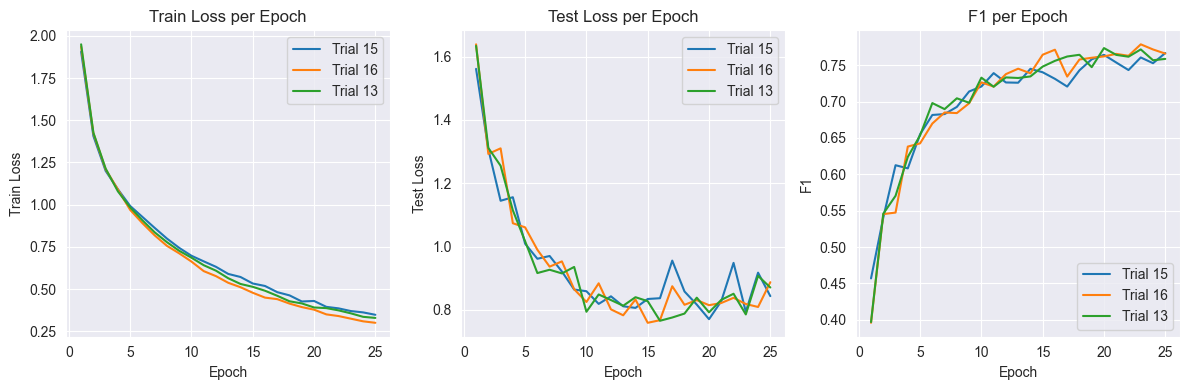

Trial 15 Parameters:
  fc_layers: (12544, 10)
  dropout_rate: 0.25
  learning_rate: 0.001
  Final F1 Score: 0.7666946481241677

Trial 16 Parameters:
  fc_layers: (12544, 10)
  dropout_rate: 0.25
  learning_rate: 0.001
  Final F1 Score: 0.7659363037890394

Trial 13 Parameters:
  fc_layers: (12544, 10)
  dropout_rate: 0.25
  learning_rate: 0.001
  Final F1 Score: 0.7586487525854689



In [43]:
plot_top_trials(study, top_n=3)